# メッシュデータの扱い

$z(x,y)$ のような形式で，$x$, $y$が等間隔のメッシュで与えられているデータを可視化してみます．
ここでは比較のためにmatplotlibも使います．

In [2]:
import pygmt
import numpy as np
import matplotlib.pyplot as plt

## 等間隔メッシュデータ

まず，サンプルとして NumPy で適当な等間隔データを作成してみます．

In [3]:
nx = 300
ny = 200
x = np.linspace(0, 3, nx+1)
y = np.linspace(0, 2, ny+1)

```{margin}
長らくリスト `z`の `i,j` の順序が逆になっていました（等方的な図のうえ，XY方向のサイズも等しいため気が付きませんでした．お詫びします．(2025/02/25)
```

In [4]:
z = np.zeros([ny+1,nx+1])

for i in range(nx):
    for j in range(ny):
        a = np.pi * ( x[i]    - np.sqrt(3.0) * y[j] )
        b = np.pi * ( 3.*x[i] + np.sqrt(3.0) * y[j] )
        z[j,i] = np.cos(2*a) * np.cos(4*b) + np.cos(5*a) * np.cos(3*b) + np.cos(7*a) * np.cos(b)

試しにmatplotlibでプロットしてみると，以下のような感じです．

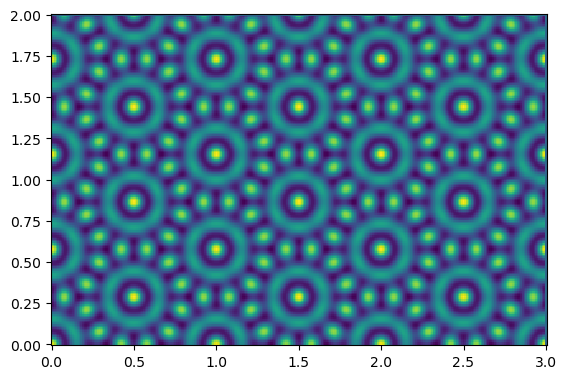

In [5]:
g = plt.subplot()
g.pcolormesh(x, y, z, shading='auto')
g.set_aspect('equal')

このデータを pygmt の `xyz2grd` を用いて grdデータにしてプロットしてみます．

```{margin}
`xarray`を用いる方法は[染矢（@someya）](https://github.com/msomeya1)さんに[ご教示](https://github.com/tktmyd/pygmt-howto-jp/issues/2)いただきました．記して感謝いたします．
```

````{note}
`xyz2grd` はx, y, zそれぞれ1次元配列にしないと渡せないようです．そのため，`np.meshgrid()`と `ravel()` メソッドを通じて `nx * ny` サイズの1次元配列を作っています．

もうすこしスッキリした書き方としては，`x`, `y`, `z`の代わりにそれらがパッキングされた`data`リストを内包表記を用いて与える方法もあります: 
```python
pygmt.xyz2grd(
    data = [[x[i], y[j], z[i,j]] for i in range(len(x)) for j in range(len(y))]
    # 他の要素は省略
    )
```

さらに発展的な方法として，`xarray` モジュールを用いて，以下のように表現することもできます．
```python
import xarray as xr
grddata = xr.DataArray(
    data = z,
    dims = ["y", "x"],
    coords = {"y": y, "x": x}
)
```
この方法は高速なだけでなく，PyGMTがグリッドデータのPython内部オブジェクトとしてxarrayを用いている点からもより直接的で好ましい方法と思われます．`xyz2grd`モジュールとことなり，わざわざxy方向のグリッド間隔を明示的に指定する必要がないのも好ましい点です．
````

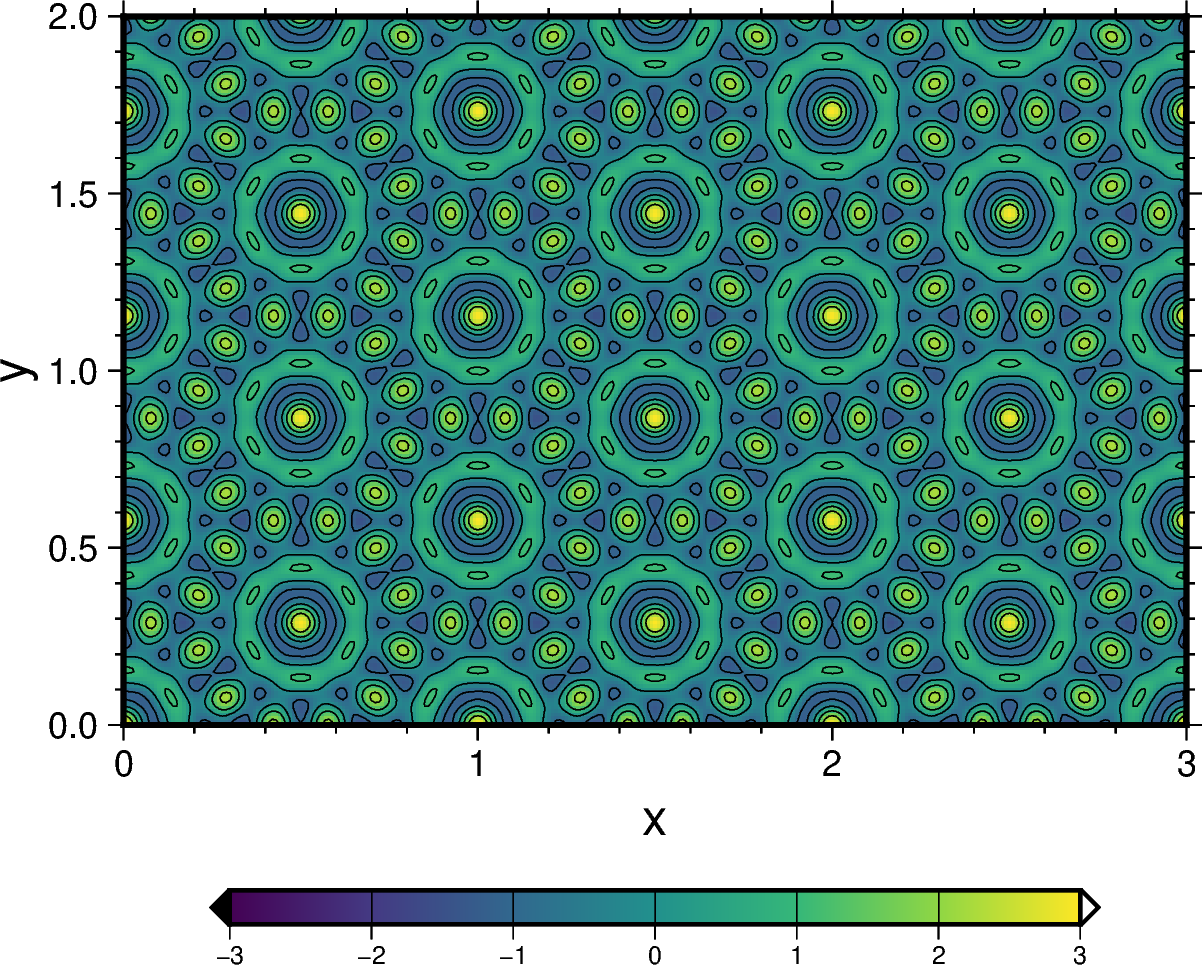

In [8]:
fig = pygmt.Figure()

X, Y = np.meshgrid(x, y)

grddata = pygmt.xyz2grd(
    region = [0, 3, 0, 2],     
    spacing = '0.01/0.01', 
    x = X.ravel(),
    y = Y.ravel(), 
    z = z.ravel()
)

pygmt.makecpt(
    cmap       = 'viridis',     # 比較のためカラーパレットはほとんど同じものを使う
    series     = [-3, 3, 1], 
    continuous = True
)

fig.grdimage(
    grid       = grddata, 
    projection = 'X9c/6c', 
    frame      = ['WSen', 'xaf+lx', 'yaf+ly'],    
)

fig.grdcontour(
    grid     = grddata, 
    levels   = 1, 
    pen      = 'default,black'
)

fig.colorbar(
    position = '+e'    
)

fig.show()

ここでは，`grdimage`のほかに`grdcontour`も用いて等値線も描画してみました．使い方は上記の例を見ればほとんど明らかだと思います．

```{note}
`grdcontour` で等値線の間隔を指定するオプションは，従来は `intervals` でしたが，v0.12.0 からは `levels` に変更されました．
```

## 2次元データの補間と可視化

続いて，粗いデータを補間しつつプロットしてみましょう．

サンプルデータとして，Wikipediaの[双3次補間](https://en.wikipedia.org/wiki/Bicubic_interpolation)の解説にある例を採用します．[ここ](https://commons.wikimedia.org/wiki/File:Interpolation-bicubic.svg)からコードをお借りして（Creditはリンク先参照；CC-BY），以下のようなデータを使います．まずはデータ生成とmatplolibでの標準的可視化の例を示します．

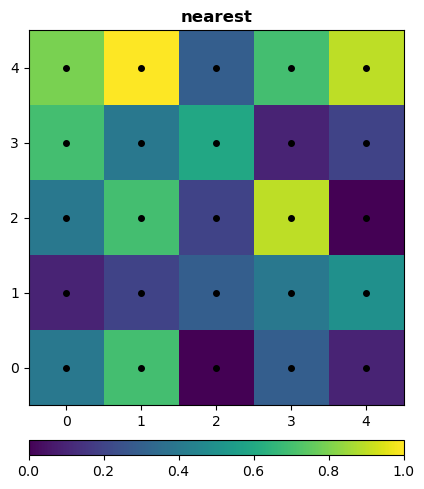

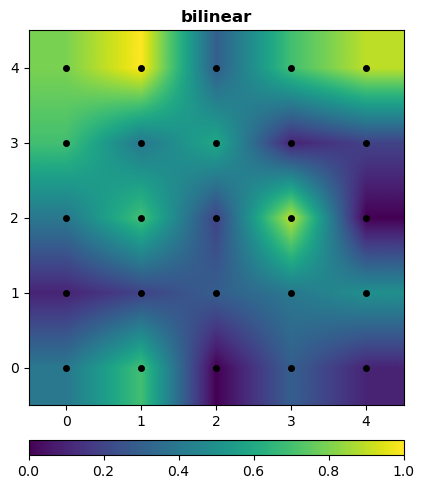

In [8]:
METHODS = [ 'nearest', 'bilinear' ]
COLORS  = 'viridis'

N = 5
np.random.seed(1)
grid = np.arange(0, N, 1)
data = np.round(np.random.rand(N, N), 1)
mesh = np.meshgrid(grid, grid)

for interp in METHODS:

    fig = plt.figure(figsize=(5,5))

    ax = fig.add_axes([0.125, 0.175, 0.75, 0.75])
    plt.imshow(data, interpolation=interp, cmap=COLORS, vmin=0, vmax=1)
    plt.plot(mesh[0], mesh[1], marker='.', ms=8, color='k', lw=0)
    plt.title(interp, weight='bold')
    plt.xlim(grid.min()-0.5, grid.max()+0.5)
    plt.ylim(grid.min()-0.5, grid.max()+0.5)
    plt.xticks(grid)
    plt.yticks(grid)

    cax = fig.add_axes([0.125, 0.075, 0.75, 0.03])
    cb = plt.colorbar(cax=cax, orientation='horizontal',
                      ticks=np.linspace(0, 1, 6))
    cb.solids.set_edgecolor('face')

ここで作られたデータを `ravel()`メソッド1次元化し，`pygmt.surface`で補間をしてみます．比較のため `pygmt.xyz2grd` で粗い間隔のままのプロットも作成します．

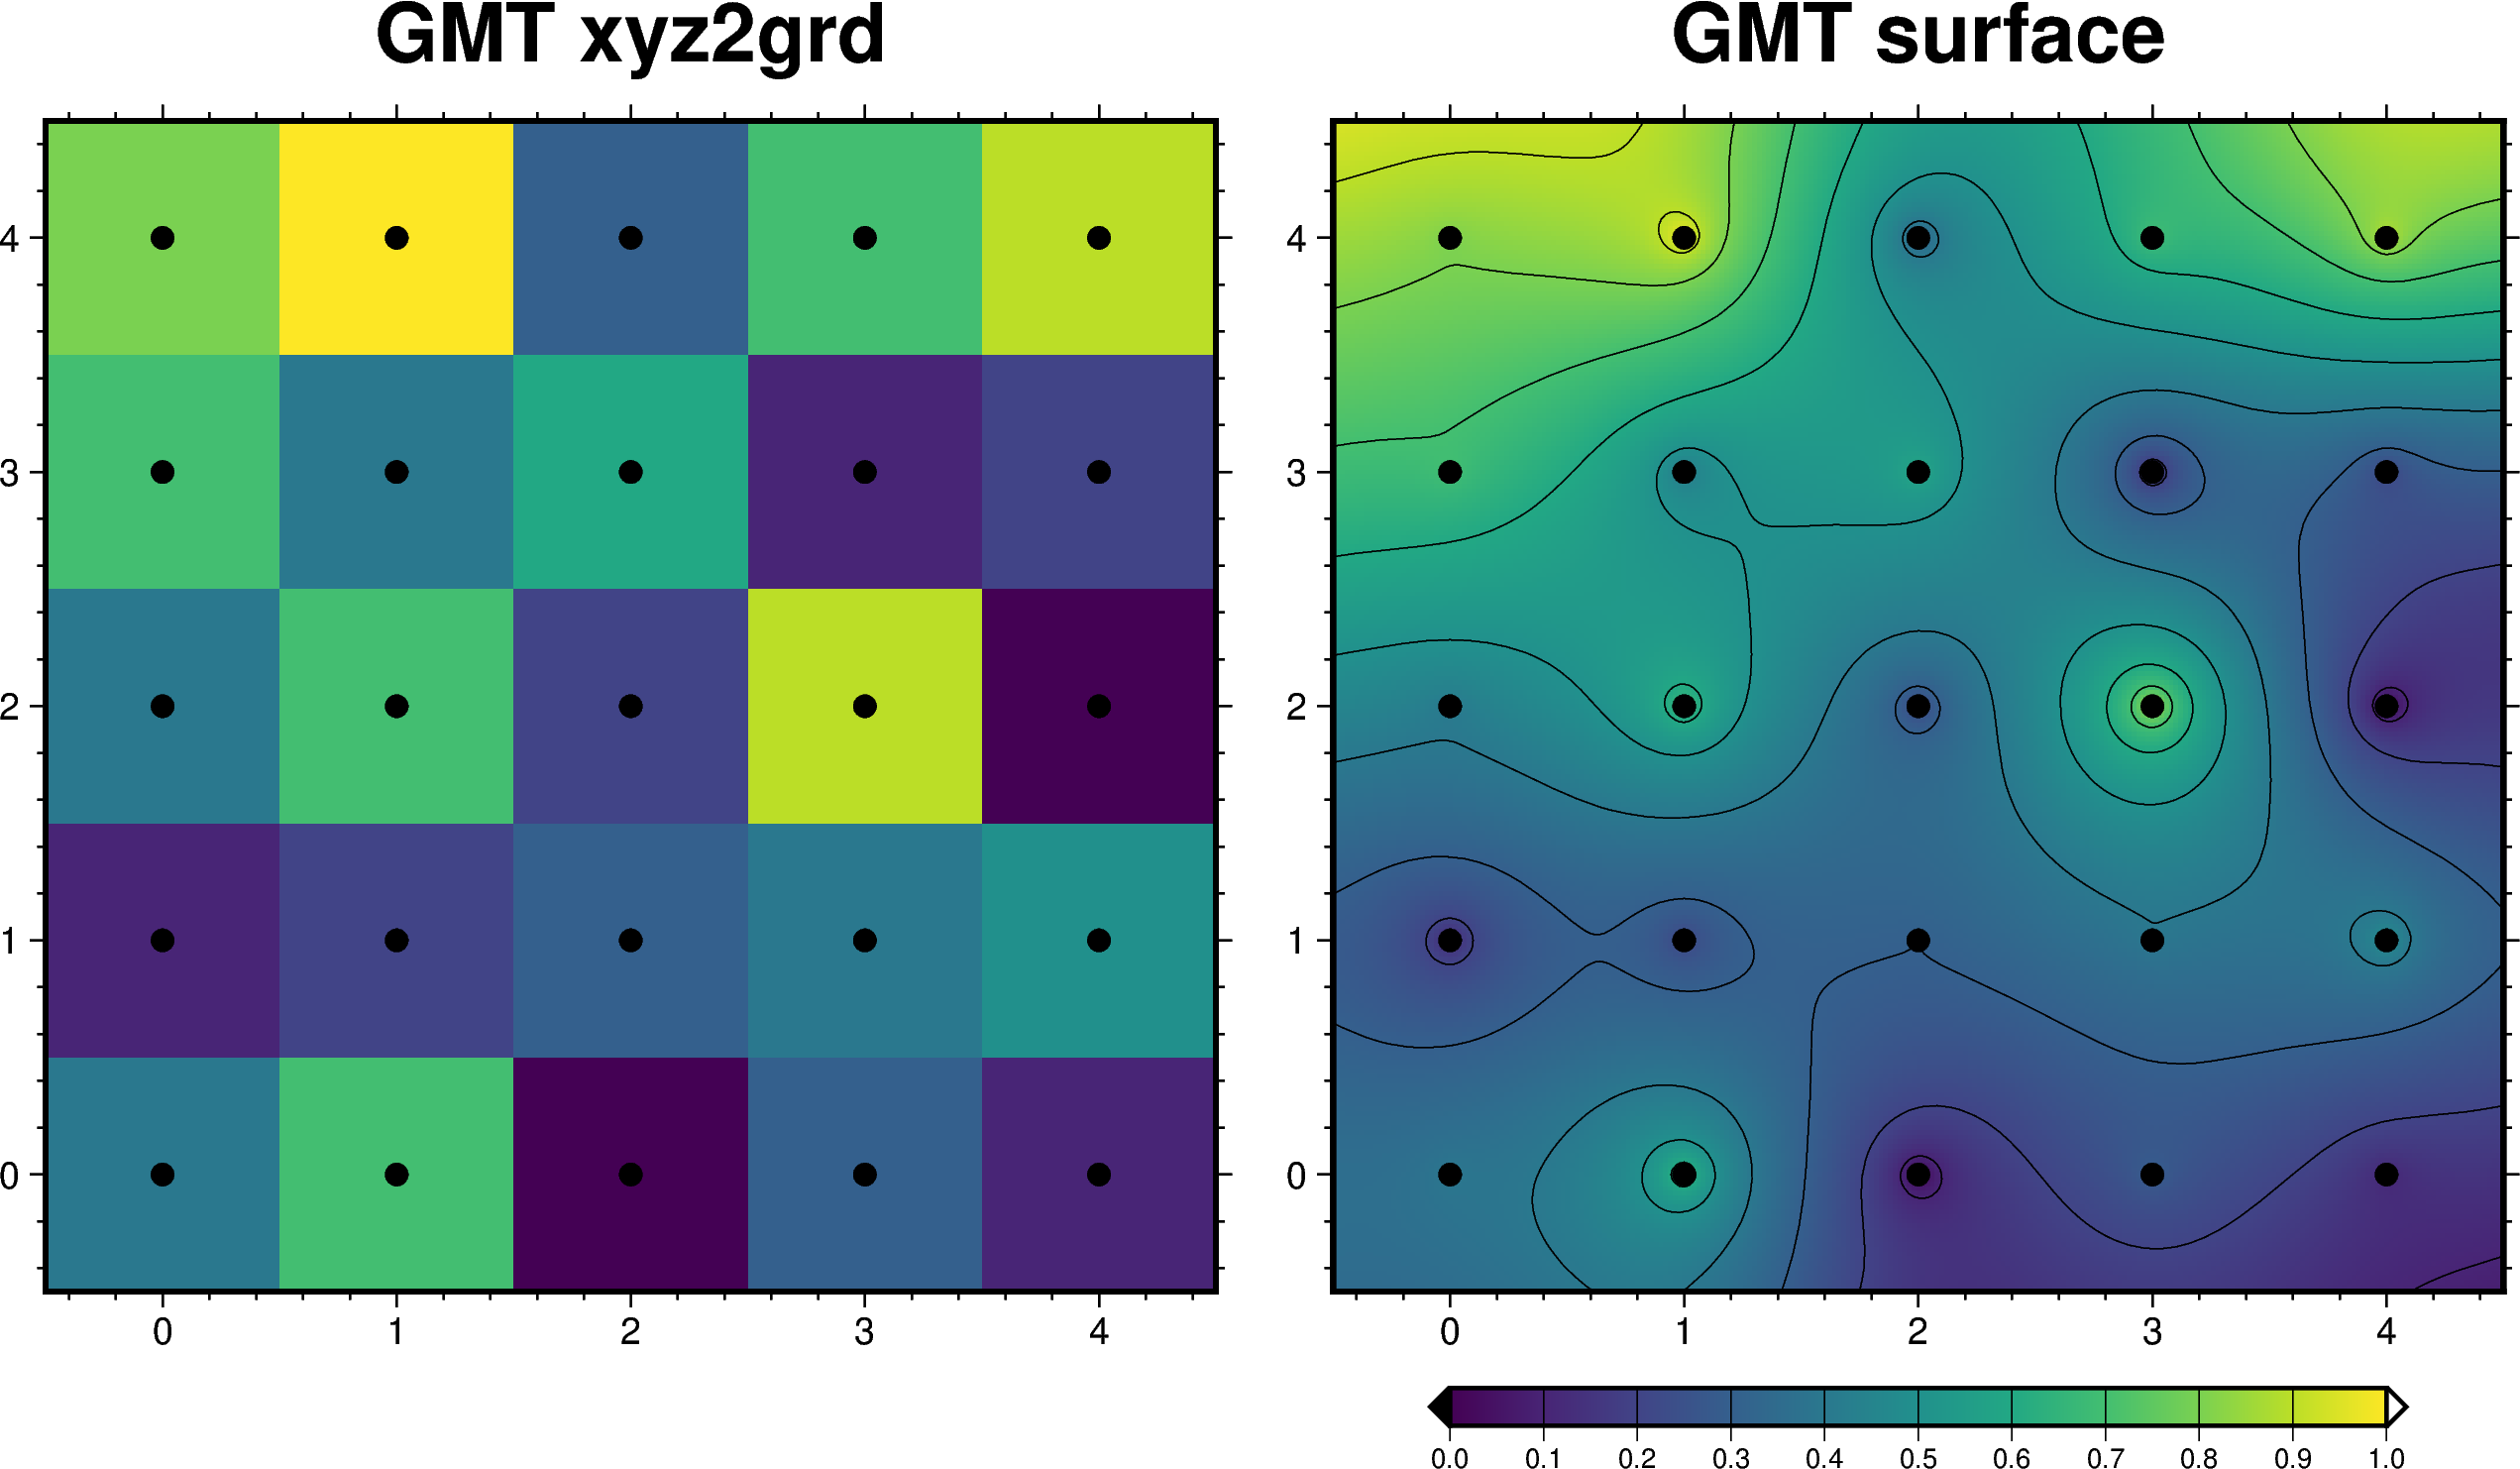

In [9]:
fig = pygmt.Figure()

griddata_s = pygmt.surface(
    x       = mesh[0].ravel(), 
    y       = mesh[1].ravel(), 
    z       = data.ravel(), 
    region  = [-0.5, 4.5, -0.5, 4.5], 
    spacing = '0.02/0.02',
    tension = 0.5 # 無指定は0
)

griddata_x = pygmt.xyz2grd(
    x       = mesh[0].ravel(), 
    y       = mesh[1].ravel(), 
    z       = data.ravel(), 
    region  = [-0.5, 4.5, -0.5, 4.5], 
    spacing = '1/1',
    registration = 'p'
)


pygmt.makecpt(
    cmap = 'viridis', 
    series = [0, 1, 0.1], 
    continuous = True
)

fig.grdimage(
    grid = griddata_x, 
    projection = 'X10c/10c',
    frame = ['WSen+tGMT xyz2grd', 'xaf', 'yaf'], 
)

fig.plot(
    x = mesh[0].ravel(), 
    y = mesh[1].ravel(), 
    style = 'c0.2c', 
    fill  = 'black', 
)

# 右にずれる
fig.shift_origin( xshift = 11 )

fig.grdimage(
    grid = griddata_s, 
    projection = 'X10c/10c',
    frame = ['WSen+tGMT surface', 'xaf', 'yaf']    
)

fig.grdcontour( 
    grid = griddata_s, 
    pen = 'default,black', 
    annotation = '-'
)

fig.plot(
    x = mesh[0].ravel(), 
    y = mesh[1].ravel(), 
    style = 'c0.2c', 
    fill  = 'black', 
)

fig.colorbar(
    position = '+e'    
)

fig.show()

```{note}
`pygmt.surface` は tension factor $t$ という量で補間の状況をコントロールします．その値を指定するオリジナルのGMTの `-T` オプションは，v0.8.0までが正式には実装されていませんでしたが， `pygmt.surface{T = }` とすると動作する状態でした．この `T` はオリジナルのGMTの`surface`モジュールのオプション名です．

v0.9.0から公式に `pygmt.surface` に GMTの`T`オプションに相当する`tension`オプションが実装されたようです．
```

`surface`による補間の挙動は，`tension`パラメタによってだいぶ変わります．`tension`を変えてみて，補間の違いを見てみましょう．

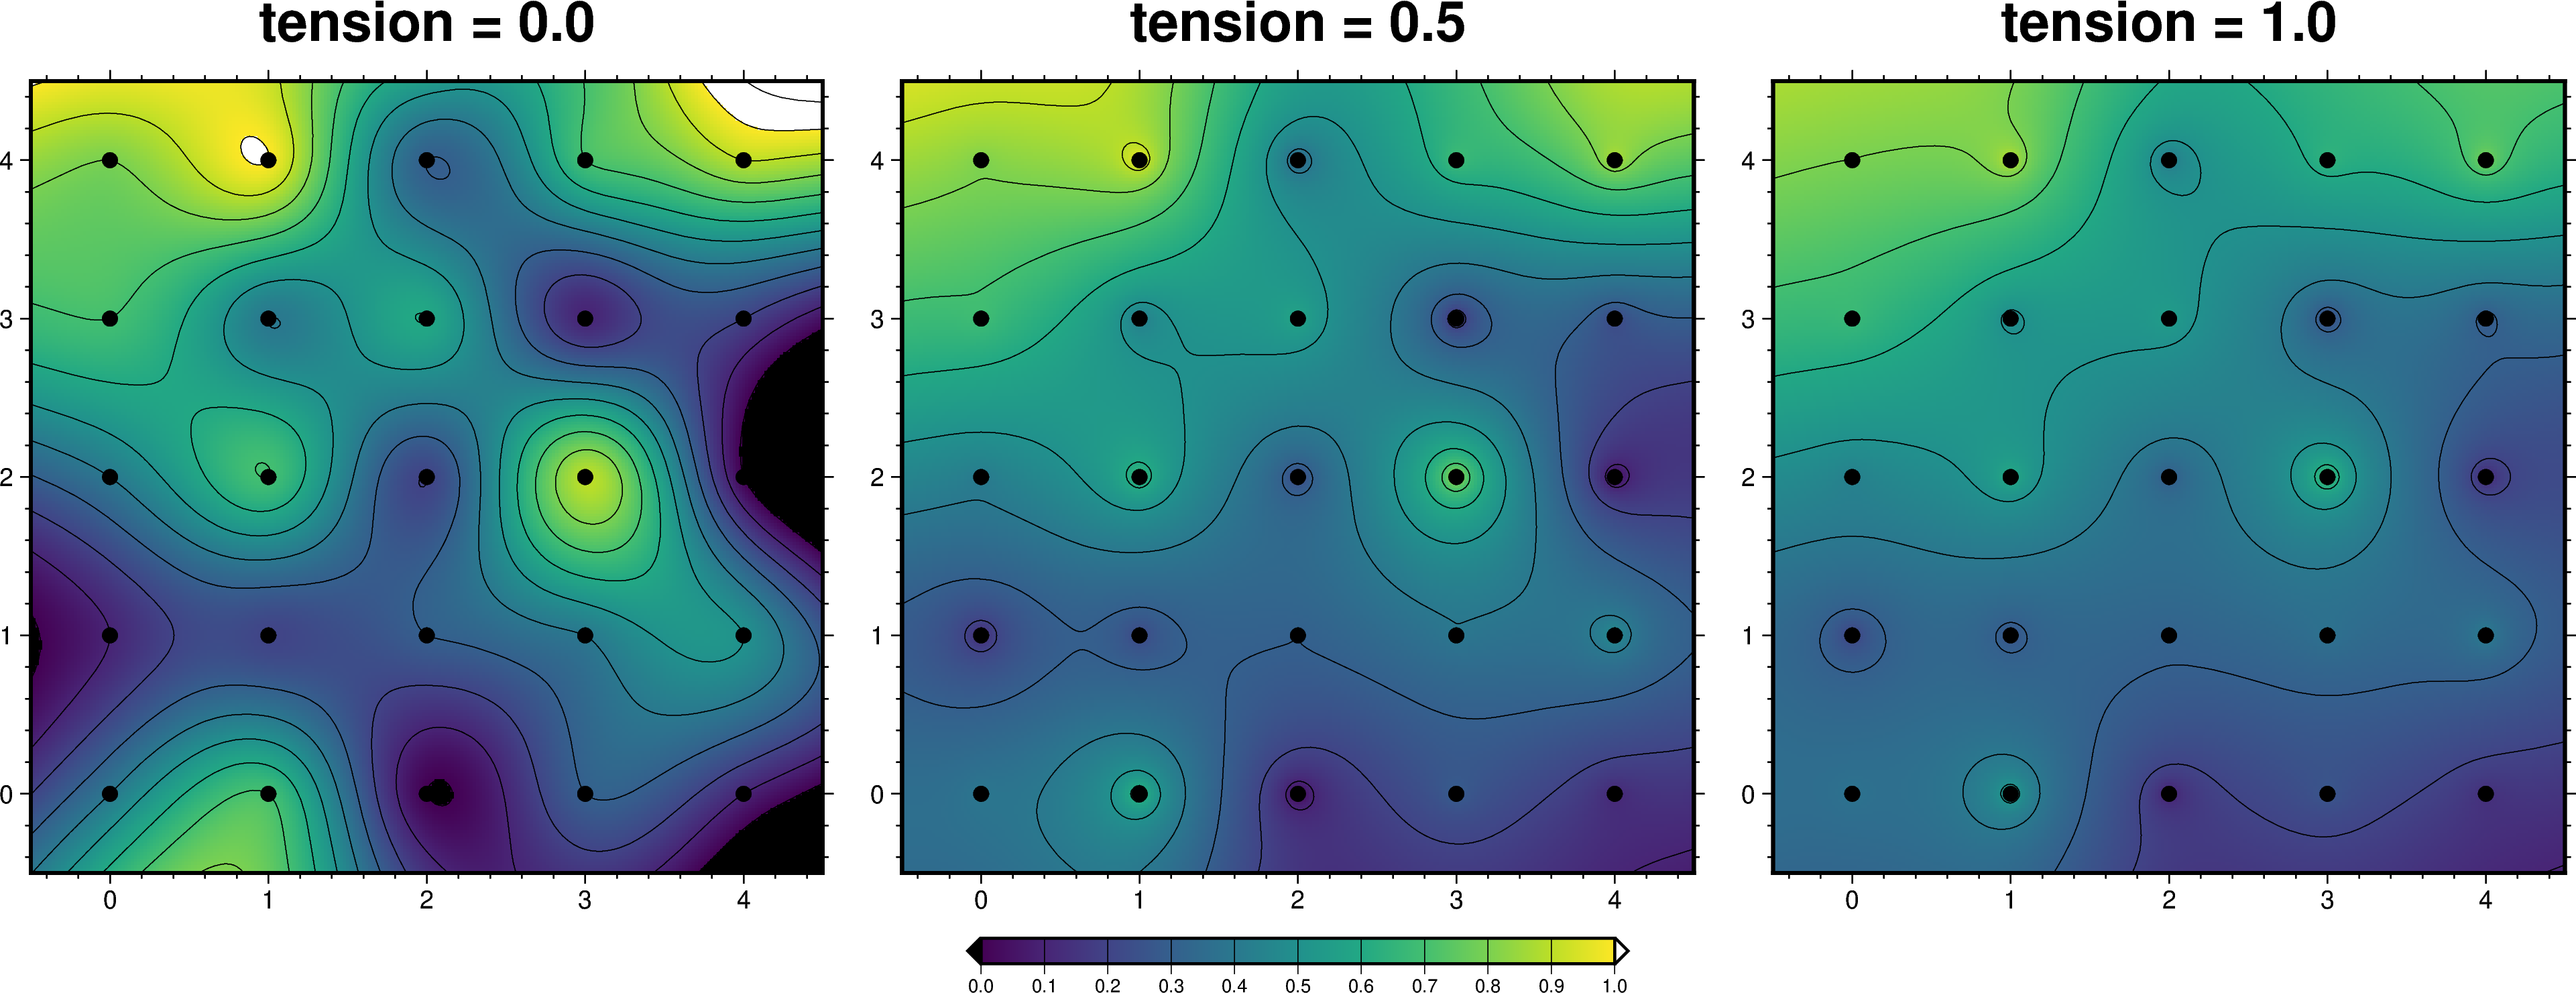

In [10]:
fig = pygmt.Figure()

pygmt.makecpt(
    cmap = 'viridis', 
    series = [0, 1, 0.1], 
    continuous = True
)

griddata_s0 = pygmt.surface(
    x       = mesh[0].ravel(), 
    y       = mesh[1].ravel(), 
    z       = data.ravel(), 
    region  = [-0.5, 4.5, -0.5, 4.5], 
    spacing = '0.02/0.02',
    tension = 0.0 
)
griddata_s1 = pygmt.surface(
    x       = mesh[0].ravel(), 
    y       = mesh[1].ravel(), 
    z       = data.ravel(), 
    region  = [-0.5, 4.5, -0.5, 4.5], 
    spacing = '0.02/0.02',
    tension = 0.5 
)
griddata_s2 = pygmt.surface(
    x       = mesh[0].ravel(), 
    y       = mesh[1].ravel(), 
    z       = data.ravel(), 
    region  = [-0.5, 4.5, -0.5, 4.5], 
    spacing = '0.02/0.02',
    tension = 1.0 
)


fig.grdimage(
    grid = griddata_s0, 
    projection = 'X10c/10c',
    frame = ['WSen+ttension = 0.0', 'xaf', 'yaf']    
)

fig.grdcontour( 
    grid = griddata_s0, 
    pen = 'default,black', 
    annotation = '-'
)

fig.plot(
    x = mesh[0].ravel(), 
    y = mesh[1].ravel(), 
    style = 'c0.2c', 
    fill  = 'black', 
)

# 右にずれる
fig.shift_origin( xshift = 11 )

fig.grdimage(
    grid = griddata_s1, 
    projection = 'X10c/10c',
    frame = ['WSen+ttension = 0.5', 'xaf', 'yaf']    
)

fig.grdcontour( 
    grid = griddata_s1, 
    pen = 'default,black', 
    annotation = '-'
)

fig.plot(
    x = mesh[0].ravel(), 
    y = mesh[1].ravel(), 
    style = 'c0.2c', 
    fill  = 'black', 
)

fig.colorbar(
    position = '+e'    
)

# 右にずれる
fig.shift_origin( xshift = 11 )


fig.grdimage(
    grid = griddata_s2, 
    projection = 'X10c/10c',
    frame = ['WSen+ttension = 1.0', 'xaf', 'yaf']    
)

fig.grdcontour( 
    grid = griddata_s2, 
    pen = 'default,black', 
    annotation = '-'
)

fig.plot(
    x = mesh[0].ravel(), 
    y = mesh[1].ravel(), 
    style = 'c0.2c', 
    fill  = 'black', 
)

fig.show()